In [63]:
import pandas as pd
import datetime as dt
import backtrader as bt
import quantstats as qs
import matplotlib as plt
import numpy as np
import os

# os.getcwd()
#(修改)股票池
stock_pool=['testCSI012','testCSI300','testCSI905']

stock_num=len(stock_pool)
#构建策略-------------------------------------
class TestSignalStrategy(bt.Strategy):
    params=()

    def log(self,txt,dt=None):
        dt= dt or self.datetime.date(0)
        print('%s,%s' % (dt.isoformat(),txt))

    def __init__(self):

        self.bar_num=0
        for i in range(stock_num):
            df=pd.read_csv('c:\\Users\\31145\\PycharmProjects\\Backtrader学习\\%s.csv' % (stock_pool[i]))
            df['date']=pd.to_datetime(df['date'])
            exec("self.signal_df%s=df" % i)
        # self.signal_df=df
        # self.signal_df['date']=pd.to_datetime(self.signal_df['date'])
        self.first_trade=[]
        for i in range(stock_num):
            self.first_trade.append(True)
        # self.first_trade=True

    def prenext(self):
        self.next()

    def next(self):
        self.bar_num+=1
        current_date=self.datas[0].datetime.date(0).strftime("%Y-%m-%d")
        try:
            next_date =self.datas[0].datetime.date(1)
        except:
            next_date=None
        if next_date != None:
            next_signal_df=[]
            for i in range(stock_num):
                next_signal_df.append(0)
            next_signal_df[0]= self.signal_df0[self.signal_df0['date']==pd.to_datetime(next_date)]
            next_signal_df[1]= self.signal_df1[self.signal_df1['date']==pd.to_datetime(next_date)]
            next_signal_df[2]= self.signal_df2[self.signal_df2['date']==pd.to_datetime(next_date)]
            #(修改)更改股票池后去掉下面的#
            # next_signal_df[3]= self.signal_df3[self.signal_df3['date']==pd.to_datetime(next_date)]
            # next_signal_df[4]= self.signal_df4[self.signal_df4['date']==pd.to_datetime(next_date)]
            # next_signal_df[5]= self.signal_df5[self.signal_df5['date']==pd.to_datetime(next_date)]
            # next_signal_df[6]= self.signal_df6[self.signal_df6['date']==pd.to_datetime(next_date)]
            # next_signal_df[7]= self.signal_df7[self.signal_df7['date']==pd.to_datetime(next_date)]
            # next_signal_df[8]= self.signal_df8[self.signal_df8['date']==pd.to_datetime(next_date)]
            # next_signal_df[9]= self.signal_df9[self.signal_df9['date']==pd.to_datetime(next_date)]
            if len(next_signal_df[0])==0:
                self.log("下个交易日的信号不存在")
            else:
                buy_stock_num=0
                for i in range(stock_num):
                    signal=int(next_signal_df[i]['signal'])
                    if signal==1:
                        buy_stock_num+=1
                for i in range(stock_num):
                    signal=int(next_signal_df[i]['signal'])
                    
                    # signal = int(next_signal_df['signal'])

                    #第一次交易没有底仓，只允许做多
                    #交易信号的执行方式：
                    #先不考虑卖空
                    #signal为1，以当天开盘价全仓买入
                    #signal为-1时，以当天开盘价卖出所有持仓
                    #添加两个变量，一个是第一个signal=1的bar，第二个是每一次bar里有多少个买入的signal，第三是实现先卖后买

                    if self.first_trade[i]==True:
                        if signal==-1:
                            pass
                        if signal== 1:
                            # total_value = self.broker.get_value()
                            print("当天买入信号的股票数有%.2f"%buy_stock_num)
                            total_cash=self.broker.get_cash()
                            open_price = self.datas[i].open[0]
                            target_size=(total_cash/buy_stock_num)//open_price
                            # target_size=(total_cash/stock_num)//open_price
                            self.buy(self.datas[i],size=target_size,price=open_price)
                            self.first_trade[i]=False
                    else:
                        #调仓逻辑：当天持有的现金平均分配到买入的股票上
                        #现有持仓
                        now_hold_size = self.getposition(self.datas[i]).size
                        if signal == 1:
                            total_cash = self.broker.get_cash()
                            open_price = self.datas[i].open[0]
                            target_size=(total_cash/buy_stock_num)//open_price
                            self.buy(self.datas[i],size=target_size, price=open_price)

                        if signal == -1:
                            total_value = self.broker.get_value()
                            open_price = self.datas[i].open[0]
                            # target_size=total_value//open_price
                            # #卖出开仓，手数不能超过底仓
                            # if target_size>now_hold_size:
                            #     target_size=now_hold_size

                            self.sell(self.datas[i],size=now_hold_size, price=open_price)

    #订单情况
    def notify_order(self, order):
        
        #订单处于未决，继续
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        #订单已决
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('买单执行，价格:%.2f,数量:%.2f' % (order.executed.price,order.executed.size))

            elif order.issell():
                self.log('卖单执行,价格：%2f,数量:%.2f' % (order.executed.price,order.executed.size))
        
        elif order.status in [order.Canceled,order.Rejected,order.Expired]:
            self.log('订单 Canceled/Rejected/Expired')

    #交易情况
    def notify_trade(self, trade):
        if trade.isclosed:
            print('毛收益 %0.2f, 扣佣后收益 % 0.2f , 佣金 %.2f'
            % (trade.pnl, trade.pnlcomm, trade.commission))
        


cerebro=bt.Cerebro()


In [64]:
#获取当前路径，用于之后添加股票文件
os.getcwd()

'c:\\Users\\31145\\PycharmProjects\\Backtrader学习'

In [65]:
#起始日期和终止日期
fromdate=dt.datetime(2014, 3, 7)
todate=dt.datetime(2021, 12, 30)


#数据加载-------------------------------------


initial_open=[]
for i in range(len(stock_pool)):
    #(修改)文件路径 
    df=pd.read_csv('c:\\Users\\31145\\PycharmProjects\\Backtrader学习\\%s.csv' % (stock_pool[i]))
    df.index=pd.to_datetime(df.date)
    df['openinterest']=0
    stock_df=df[['open','high','low','close','volume','openinterest']]
    initial_open.append(df[df['date']==fromdate]['open'])
    data=bt.feeds.PandasData(dataname=stock_df,fromdate=fromdate, todate=todate,timeframe=bt.TimeFrame.Days)
    cerebro.adddata(data,name=stock_pool[i])




#滑点设置 0.5%
cerebro.broker = bt.brokers.BackBroker(slip_perc=0.005)
#初始资金设置为100万，每只股票分配10万
initial_cash=900000.0
cerebro.broker.setcash(initial_cash)
#手续费万分之二
cerebro.broker.setcommission(commission=0.0002)

cerebro.addstrategy(TestSignalStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio,_name='PyFolio')

#运行回测
print('start portfolio value:',format(cerebro.broker.getvalue()))
results = cerebro.run()
print('end portfolio value:',format(cerebro.broker.getvalue()))


#绩效评价----------------------------
#获取策略实例
start = results[0]
portfolio_stats = start.analyzers.getbyname('PyFolio')
#以下returns为以日期为索引的资产日收益率序列
returns,positions,transactions,gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

start portfolio value: 900000.0
当天买入信号的股票数有2.00
当天买入信号的股票数有2.00
2014-03-10,买单执行，价格:140.05,数量:3214.00
2014-03-10,买单执行，价格:3981.51,数量:111.00
2014-03-11,买单执行，价格:140.08,数量:27.00
2014-03-12,买单执行，价格:139.90,数量:28.00
2014-03-12,卖单执行,价格：3857.580000,数量:-111.00
毛收益 -13756.23, 扣佣后收益 -13930.26 , 佣金 174.03
2014-03-20,买单执行，价格:140.04,数量:1528.00
2014-03-20,买单执行，价格:3973.15,数量:53.00
2014-03-21,买单执行，价格:140.15,数量:12.00
当天买入信号的股票数有3.00
2014-03-24,买单执行，价格:140.20,数量:4.00
2014-03-25,买单执行，价格:140.26,数量:3.00
2014-03-26,买单执行，价格:140.29,数量:2.00
2014-03-27,买单执行，价格:140.29,数量:1.00
2014-03-28,买单执行，价格:140.46,数量:1.00
2014-03-31,买单执行，价格:140.38,数量:1.00
2014-03-31,卖单执行,价格：3865.000000,数量:-53.00
毛收益 -5731.95, 扣佣后收益 -5815.03 , 佣金 83.08
2014-04-01,买单执行，价格:140.55,数量:729.00
2014-04-01,买单执行，价格:2143.72,数量:47.00
2014-04-02,买单执行，价格:140.57,数量:6.00
2014-04-03,买单执行，价格:140.58,数量:3.00
2014-04-04,买单执行，价格:140.59,数量:3.00
2014-04-04,卖单执行,价格：2157.980000,数量:-47.00
毛收益 670.22, 扣佣后收益  629.78 , 佣金 40.44
2014-04-08,买单执行，价格:140.50,数量:360.00
2014-04-08

In [66]:
#benchmark--------------------------------------------------


fromdate=dt.datetime(2014, 3, 7)
todate=dt.datetime(2021, 12, 30)
initial_cash=900000.0
stock_pool=['testCSI012','testCSI300','testCSI905']


initial_open=[]
initial_size={}
for i in range(stock_num):
    #(修改)文件路径
    df=pd.read_csv('c:\\Users\\31145\\PycharmProjects\\Backtrader学习\\%s.csv' % (stock_pool[i]))
    df['date']=pd.to_datetime(df['date'])
    df.index=df['date']
    initial_open.append(int(df[df['date']==fromdate]['open']))
    # initial_size[stock_pool[i]]=initial_cash/stock_num//int(df[df['date']==fromdate]['open'])
    # benchmark+=initial_size[stock_pool[i]]*df['close']
# print(initial_open)

n=0
for i in stock_pool:
    initial_size[i]=initial_cash/3//initial_open[n]
    n=n+1

benchmark=0
for i in range(stock_num):
    #(修改)文件路径
    df=pd.read_csv('c:\\Users\\31145\\PycharmProjects\\Backtrader学习\\%s.csv' % (stock_pool[i]))
    df['date']=pd.to_datetime(df['date'])
    df.index=df['date']
    benchmark+=initial_size[stock_pool[i]]*df['close']


[140, 2170, 4032]


                    Strategy
------------------  ----------
Start Period        2014-03-07
End Period          2021-12-30
Risk-Free Rate      0.0%
Time in Market      92.0%

Cumulative Return   33.83%
CAGR﹪              3.8%

Sharpe              4.21
Prob. Sharpe Ratio  100.0%
Sortino             5.48
Sortino/√2          3.88
Omega               2.88

Max Drawdown        -2.09%
Longest DD Days     336

Gain/Pain Ratio     1.88
Gain/Pain (1M)      9.47

Payoff Ratio        0.95
Profit Factor       2.88
Common Sense Ratio  5.04
CPC Index           2.06
Tail Ratio          1.75
Outlier Win Ratio   4.51
Outlier Loss Ratio  2.87

MTD                 0.41%
3M                  1.05%
6M                  2.58%
YTD                 4.24%
1Y                  4.29%
3Y (ann.)           4.02%
5Y (ann.)           3.78%
10Y (ann.)          3.8%
All-time (ann.)     3.8%

Avg. Drawdown       -0.06%
Avg. Drawdown Days  9
Recovery Factor     16.18
Ulcer Index         0.0
Serenity Index      9.0


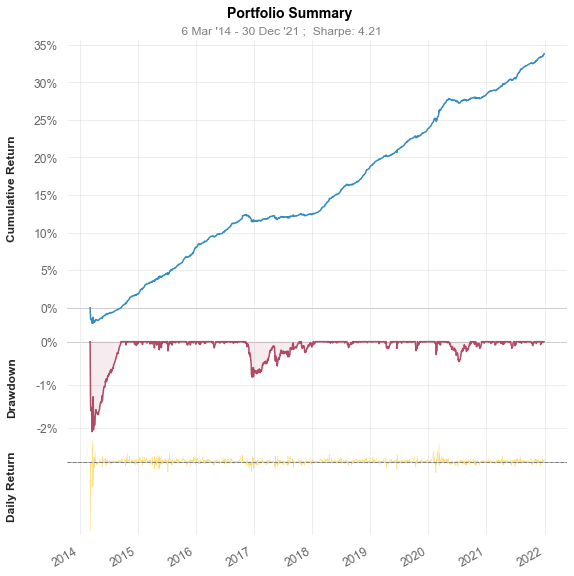

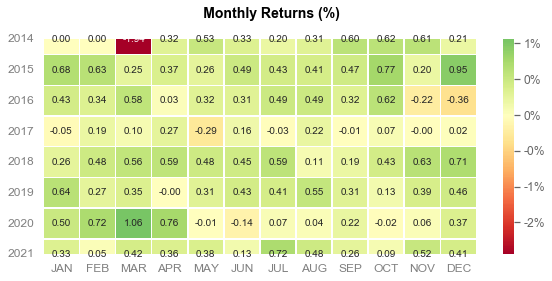

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2014-03-07  2014-03-07
End Period                 2021-12-30  2021-12-30
Risk-Free Rate             0.0%        0.0%
Time in Market             92.0%       100.0%

Cumulative Return          33.83%      81.97%
CAGR﹪                     3.8%        7.95%

Sharpe                     4.21        0.54
Prob. Sharpe Ratio         100.0%      93.37%
Smart Sharpe               4.07        0.52
Sortino                    5.48        0.72
Smart Sortino              5.3         0.69
Sortino/√2                 3.88        0.51
Smart Sortino/√2           3.75        0.49
Omega                      2.88        2.88

Max Drawdown               -2.09%      -43.69%
Longest DD Days            336         2390
Volatility (ann.)          0.91%       17.61%
R^2                        0.0         0.0
Information Ratio          -0.02       -0.02
Calmar                     1.82       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2014-03-10,2014-03-20,2014-09-19,193,-2.091390,-1.944806
2,2016-11-10,2016-12-20,2017-10-12,336,-0.826930,-0.777190
3,2020-05-11,2020-07-10,2020-09-22,134,-0.464517,-0.448122
4,2020-02-11,2020-02-20,2020-02-26,15,-0.301313,-0.245514
5,2017-10-26,2017-11-15,2018-01-08,74,-0.248346,-0.242137


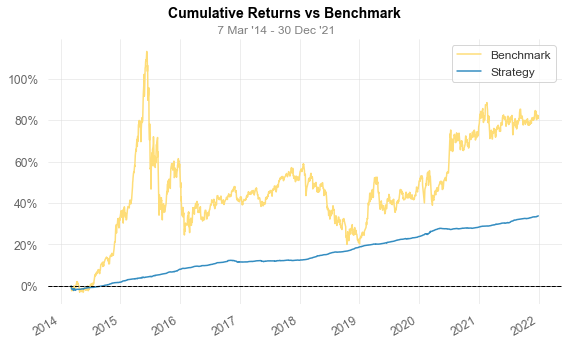

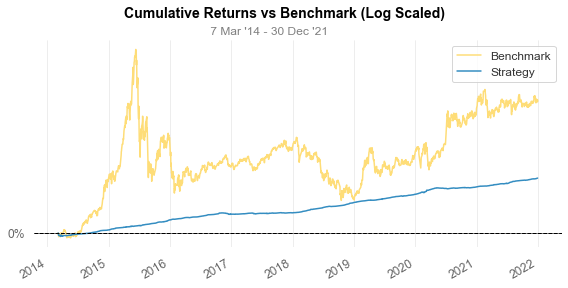

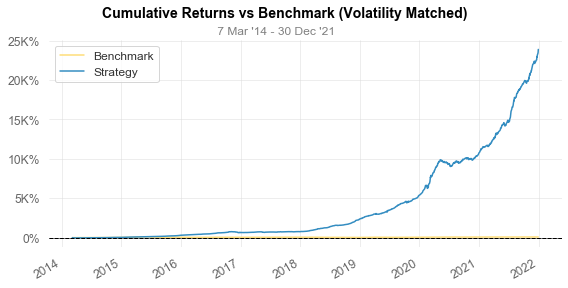

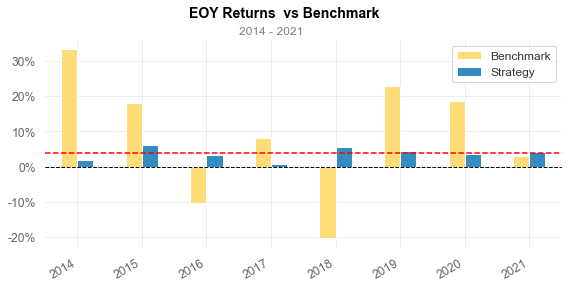

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

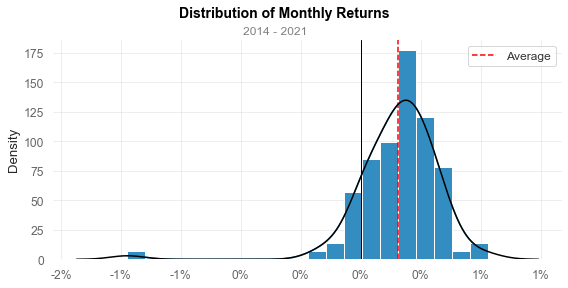

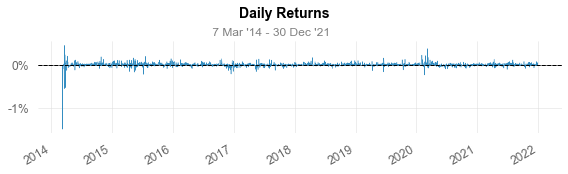

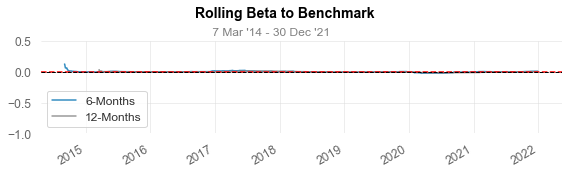

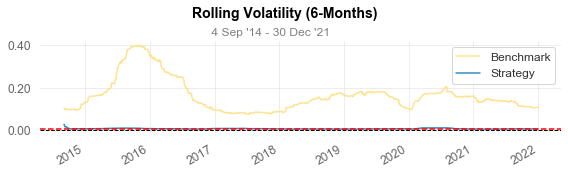

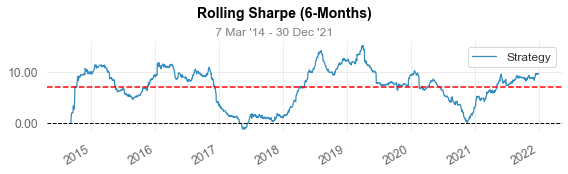

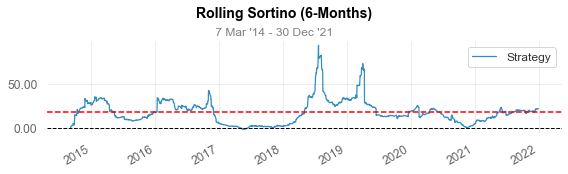

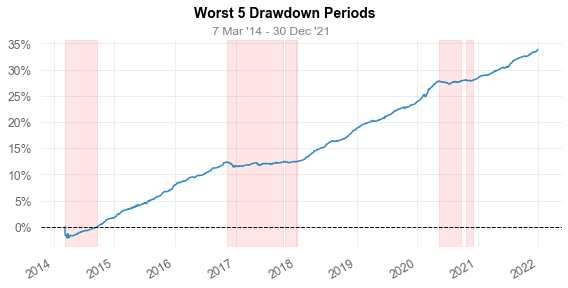

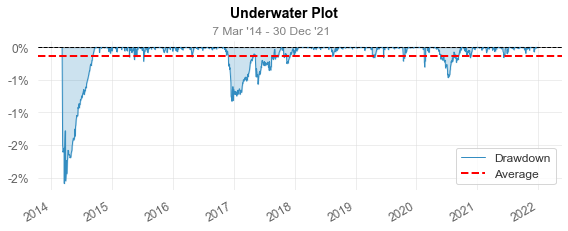

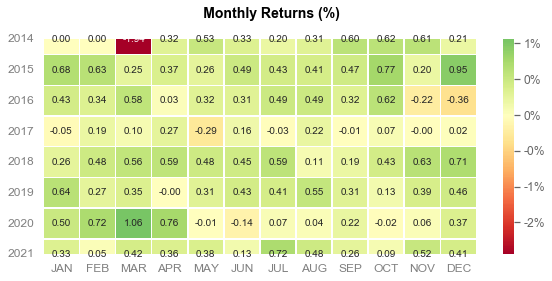

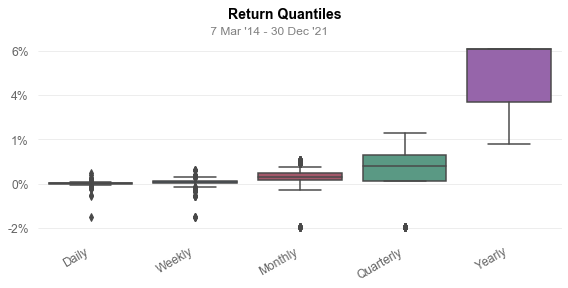

In [67]:
#画图仍只能在notebook中输出
qs.reports.basic(returns,rf=0.0,grayscale=False,display=True,compounded = True)
#只有在full中有和benchmark的对比
qs.reports.full(returns,benchmark=benchmark,rf=0.0,grayscale=False,display=True,compounded = True)